# **Phase (3): Model Training & Validation**

**1.Import the necessary libraries**

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,\
confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

**2. Load the data**

In [29]:
data_path = 'data/engineered_data.csv'

df = pd.read_csv(data_path)

CATEGORICAL_COLS = ['sex', 'fbs', 'exang', 'ca', 'slope', 'target',\
                   'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'restecg_2',\
                    'thal_2', 'thal_3']
NUMERIC_COLS = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'Age_BP_Interaction',\
               'Age_Chol_Interaction', 'Chol_BP_Interaction', 'BP_Chol_Ratio',\
               'Age_Squared', 'Chol_Squared']

In [30]:
df.head(2)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_2,thal_3,Age_BP_Interaction,Age_Chol_Interaction,Chol_BP_Interaction,BP_Chol_Ratio,Age_Squared,Chol_Squared
0,63,1,145,233,1,150,0,2.3,2,0,0,0,0,0,0,1,1,0,9135,14679,33785,0.622318,3969,54289
1,67,1,160,286,0,108,1,1.5,1,3,1,0,0,1,0,1,0,0,10720,19162,45760,0.559441,4489,81796


**3. Split the data**

In [31]:
# split the data
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# store models results here
y_pred = pd.DataFrame()
y_prob = pd.DataFrame()

# **4. First Model: Logistic Regression**

In [33]:
# scale the numeric data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[NUMERIC_COLS] = scaler.fit_transform(X_train_scaled[NUMERIC_COLS])
X_test_scaled[NUMERIC_COLS] = scaler.transform(X_test_scaled[NUMERIC_COLS])

In [34]:
# train model
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
# store predictions
y_pred['logisticRegression'] = lr.predict(X_test_scaled)
y_prob['logisticRegression'] = lr.predict_proba(X_test_scaled)[:,1]

# **5. Second Model: K Nearest Neighbor(KNN):**

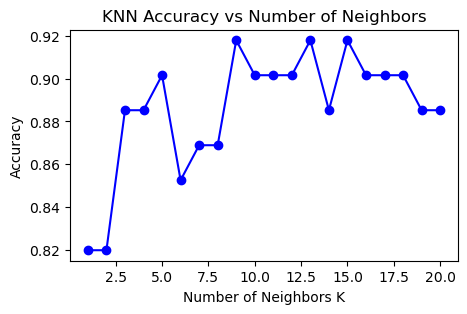

In [35]:
# Find optimal k for KNN
k_range = range(1, 21)
accuracy_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled.values, y_train)
    y_pred_knn = knn.predict(X_test_scaled.values)
    accuracy_scores.append(accuracy_score(y_test, y_pred_knn))

# Plot accuracy vs k
plt.figure(figsize=(5,3))
plt.plot(k_range, accuracy_scores, 'bo-')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.show()

In [36]:
# Use optimal k for KNN
optimal_k = k_range[np.argmax(accuracy_scores)]
print(f"Optimal k for KNN: {optimal_k}")

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_scaled.values, y_train)
y_pred['knn'] = knn.predict(X_test_scaled.values)
y_prob['knn'] = knn.predict_proba(X_test_scaled.values)[:, 1]

Optimal k for KNN: 9


# **6. Third Model: Random Forest**

In [37]:
# Train the model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Store predictions & probabilities
y_pred['randomForest'] = rf.predict(X_test)
y_prob['randomForest'] = rf.predict_proba(X_test)[:,1]

# **7. Evaluation of all models**

                Model  Accuracy  Precision    Recall  F1-score       AUC
0  logisticRegression  0.868852   0.812500  0.928571  0.866667  0.954545
1                 knn  0.918033   0.925926  0.892857  0.909091  0.951299
2        randomForest  0.885246   0.818182  0.964286  0.885246  0.957792


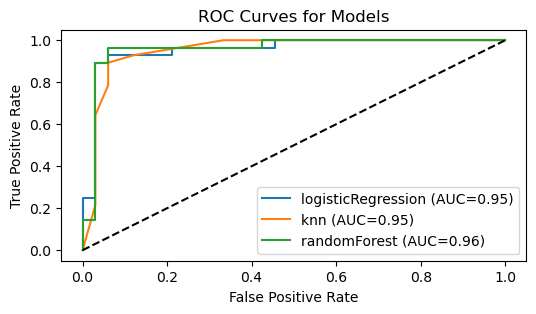

In [38]:
results = []

plt.figure(figsize=(6,3))

for model in y_pred.columns:

    # Metrics
    acc = accuracy_score(y_test, y_pred[model])
    prec = precision_score(y_test, y_pred[model])
    rec = recall_score(y_test, y_pred[model])
    f1 = f1_score(y_test, y_pred[model])
    auc = roc_auc_score(y_test, y_prob[model])

    results.append([model, acc, prec, rec, f1, auc])

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob[model])
    plt.plot(fpr, tpr, label=f"{model} (AUC={auc:.2f})")

# Results Table
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1-score","AUC"])
print(results_df)


# Plot ROC Curve
plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()

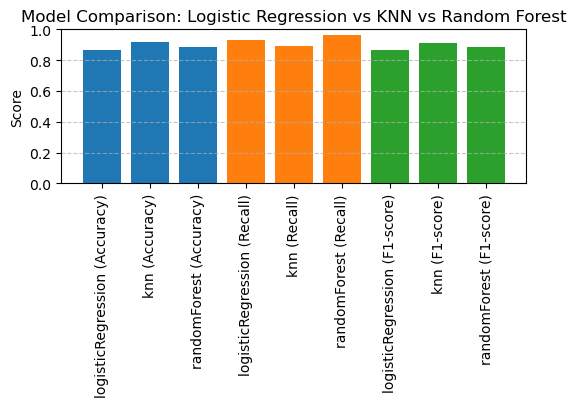

In [39]:
metrics_to_plot = ["Accuracy", "Recall", "F1-score"]

results_melted = results_df.melt(
    id_vars="Model",
    value_vars=metrics_to_plot,
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(6,2))
for metric in metrics_to_plot:
    subset = results_melted[results_melted["Metric"] == metric]
    plt.bar(
        subset["Model"] + " (" + metric + ")",
        subset["Score"],
        label=metric
    )

plt.title("Model Comparison: Logistic Regression vs KNN vs Random Forest")
plt.ylabel("Score")
plt.xticks(rotation=90)
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()